<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fgeneration/applications/generation/utterance_generation/Utterance%20Generation%20with%20BPE%20Tokenization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install youtokentome

     |████████████████████████████████| 1.7MB 2.6MB/s 


In [3]:
TASK_DATA_DIR = 'glue_data/QQP'
!test -d glue_data || git clone https://gist.github.com/60c2bdb54d156a41194446737ce03e2e.git glue_data
!test -d $TASK_DATA_DIR || python glue_data/download_glue_data.py --data_dir glue_data --tasks=QQP
!ls -alh $TASK_DATA_DIR

Cloning into 'glue_data'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21
Unpacking objects: 100% (21/21), done.
	Completed!
total 104M
drwxr-xr-x 3 root root 4.0K Jun 26 15:45 .
drwxr-xr-x 4 root root 4.0K Jun 26 15:45 ..
-rw-r--r-- 1 root root 5.6M Jun 26 15:45 dev.tsv
drwxr-xr-x 2 root root 4.0K Jun 26 15:45 original
-rw-r--r-- 1 root root  49M Jun 26 15:45 test.tsv
-rw-r--r-- 1 root root  50M Jun 26 15:45 train.tsv


In [4]:
import time
import codecs
import random
import math
import spacy
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import youtokentome
from torchtext import data, vocab

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
train_df = pd.read_csv(TASK_DATA_DIR + '/train.tsv', sep='\t', error_bad_lines=False)
valid_df = pd.read_csv(TASK_DATA_DIR + '/dev.tsv', sep='\t', error_bad_lines=False)
train_df.head()

b'Skipping line 83032: expected 6 fields, saw 7\n'
b'Skipping line 154657: expected 6 fields, saw 7\n'
b'Skipping line 323916: expected 6 fields, saw 7\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222.0,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0.0
1,402555,536040,536041.0,How do I control my horny emotions?,How do you control your horniness?,1.0
2,360472,364011,490273.0,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0.0
3,150662,155721,7256.0,What can one do after MBBS?,What do i do after my MBBS ?,1.0
4,183004,279958,279959.0,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0.0


In [8]:
len(train_df), len(valid_df)

(363192, 40372)

Text(0.5, 0, 'Train data distribution')

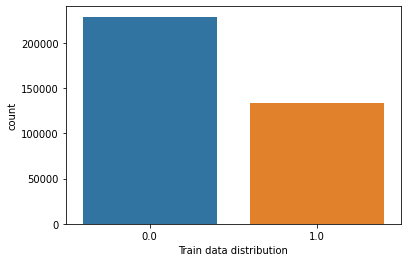

In [9]:
sns.countplot(train_df['is_duplicate'])
plt.xlabel('Train data distribution')

Text(0.5, 0, 'Valid data distribution')

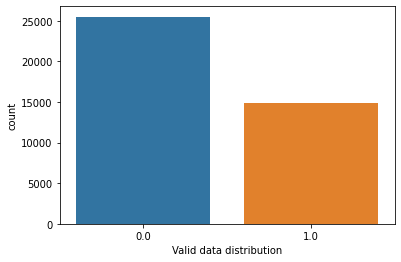

In [10]:
sns.countplot(valid_df['is_duplicate'])
plt.xlabel('Valid data distribution')

In [11]:
train_data = train_df[train_df['is_duplicate'] == 1]
valid_data = valid_df[valid_df['is_duplicate'] == 1]

In [12]:
len(train_data), len(valid_data)

(134141, 14857)

In [13]:
train_data = train_data[['question1', 'question2']]
valid_data = valid_data[['question1', 'question2']]

In [14]:
train_data.head()

,question1,question2
1,How do I control my horny emotions?,How do you control your horniness?
3,What can one do after MBBS?,What do i do after my MBBS ?
7,What is the best self help book you have read?...,What are the top self help books I should read?
11,What will be Hillary Clinton's policy towards ...,What will be Hilary Clinton's policy towards I...
13,Which is the best book to study TENSOR for gen...,Which is the best book for tensor calculus?


In [141]:
sample_train_data = train_data
sample_valid_data = valid_data

In [142]:
sample_train_data.to_csv('train_ds.csv')
sample_valid_data.to_csv('valid_ds.csv')

In [143]:
!ls -lah

total 62M
drwxr-xr-x 1 root root 4.0K Jun 26 16:19 .
drwxr-xr-x 1 root root 4.0K Jun 26 15:40 ..
-rw-r--r-- 1 root root 5.2M Jun 26 16:15 all_data.txt
-rw-r--r-- 1 root root 101K Jun 26 16:15 bpe.model
drwxr-xr-x 1 root root 4.0K Jun 19 16:15 .config
drwxr-xr-x 4 root root 4.0K Jun 26 15:45 glue_data
-rw-r--r-- 1 root root  40M Jun 26 16:33 model.pt
drwxr-xr-x 1 root root 4.0K Jun 17 16:18 sample_data
-rw-r--r-- 1 root root  15M Jun 26 16:48 train_ds.csv
-rw-r--r-- 1 root root 1.7M Jun 26 16:48 valid_ds.csv


In [144]:
# using only training data to train the BPE tokenizer
all_data = list(sample_train_data['question1'].str.lower().values) + list(sample_train_data['question2'].str.lower().values)

with codecs.open("all_data.txt", "w", encoding="utf-8") as f:
        f.write("\n".join(all_data))

In [145]:
# free some ram
del all_data

In [148]:
# Perform BPE
print("\nLearning BPE...")
youtokentome.BPE.train(data="all_data.txt", vocab_size=15000, model="bpe.model")


Learning BPE...


In [149]:
!ls -lah

total 70M
drwxr-xr-x 1 root root 4.0K Jun 26 16:19 .
drwxr-xr-x 1 root root 4.0K Jun 26 15:40 ..
-rw-r--r-- 1 root root  14M Jun 26 16:48 all_data.txt
-rw-r--r-- 1 root root 200K Jun 26 16:48 bpe.model
drwxr-xr-x 1 root root 4.0K Jun 19 16:15 .config
drwxr-xr-x 4 root root 4.0K Jun 26 15:45 glue_data
-rw-r--r-- 1 root root  40M Jun 26 16:33 model.pt
drwxr-xr-x 1 root root 4.0K Jun 17 16:18 sample_data
-rw-r--r-- 1 root root  15M Jun 26 16:48 train_ds.csv
-rw-r--r-- 1 root root 1.7M Jun 26 16:48 valid_ds.csv


In [150]:
# Load BPE model
print("\nLoading BPE model...")
bpe_model = youtokentome.BPE(model="bpe.model")


Loading BPE model...


In [151]:
# Special Tokens
print(f"<BOS>: {bpe_model.subword_to_id('<BOS>')}")    # Begining of the sentence token
print(f"<EOS>: {bpe_model.subword_to_id('<EOS>')}")    # End of the sentence token
print(f"<UNK>: {bpe_model.subword_to_id('<UNK>')}")    # Unknown token
print(f"<PAD>: {bpe_model.subword_to_id('<PAD>')}")    # Pad token

<BOS>: 2
<EOS>: 3
<UNK>: 1
<PAD>: 0


In [152]:
pad_index = bpe_model.subword_to_id('<PAD>')

In [153]:
sentence = "This is a sample sentence"
encoded_ids = bpe_model.encode(sentence.lower(), output_type=youtokentome.OutputType.ID, bos=True, eos=True)
encoded_text = bpe_model.encode(sentence.lower(), output_type=youtokentome.OutputType.SUBWORD, bos=True, eos=True)
decoded_text = bpe_model.decode(encoded_ids, ignore_ids=[2, 3])

print(encoded_ids)
print(encoded_text)
print(decoded_text)

[2, 732, 250, 225, 8472, 271, 6710, 3]
['<BOS>', '▁this', '▁is', '▁a', '▁samp', 'le', '▁sentence', '<EOS>']
['this is a sample sentence']


In [154]:
# define a tokenizer method which takes in a sentence and returns ids
# by defining this, we can configure the tokenizer to torchtext Field
def bpe_tokenizer(sentence):
    encoded_ids = bpe_model.encode(sentence.lower(), output_type=youtokentome.OutputType.ID, bos=True, eos=True)
    return encoded_ids

In [155]:
bpe_tokenizer("This is a sample sentence")

[2, 732, 250, 225, 8472, 271, 6710, 3]

In [156]:
tokenizer = data.get_tokenizer(bpe_tokenizer)
TEXT = data.Field(tokenize=tokenizer, batch_first=True, use_vocab=False, pad_token=pad_index)

In [157]:
fields = [(None, None), ("source", TEXT), ("target", TEXT)]

train_dataset, valid_dataset = data.TabularDataset.splits(path='.',
                                     train='train_ds.csv', validation='valid_ds.csv',
                                     format='csv', skip_header=True, fields=fields)

In [158]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(valid_dataset)}")

Number of training examples: 134141
Number of validation examples: 14857


In [159]:
print(vars(train_dataset.examples[1]))

{'source': [2, 243, 272, 476, 252, 539, 5008, 3], 'target': [2, 243, 252, 222, 252, 539, 301, 5360, 1223, 3]}


In [160]:
# Building vocabulary is not required as the BPE tokenizer already convert the sentence into ids

# let's check the vocab size
print(f"Vocab size: {bpe_model.vocab_size()}")

Vocab size: 15000


In [161]:
BATCH_SIZE = 64

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_dataset, valid_dataset),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.source),
    device=device
)

In [162]:
temp = next(iter(train_iterator))
temp.source.shape, temp.target.shape

(torch.Size([64, 27]), torch.Size([64, 25]))

In [163]:
class SelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout, pad_idx, device):
        super().__init__()

        assert d_model % n_heads == 0, "n_heads must be a factor of d_model"
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

        self.fc = nn.Linear(d_model, d_model)

        self.pad_idx = pad_idx
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, query, key, value, mask=None):
        # query => [batch_size, seq_len, d_model] 
        # key => [batch_size, seq_len, d_model]
        # value => [batch_size, seq_len, d_model]

        batch_size = query.shape[0]

        Q = self.q(query)
        K = self.k(key)
        V = self.v(value)
        # Q, K, V => [batch_size, seq_len, d_model]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q, K, V => [batch_size, n_heads, seq_len, head_dim]

        energy = torch.matmul(Q, K.permute(0 ,1, 3, 2))
        energy = energy / self.scale
        # energy => [batch_size, n_heads, query_len, key_len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim=-1)
        # attention => [batch_size, n_heads, query_len, key_len]

        weighted = torch.matmul(attention, V)
        # weighted => [batch_size, n_heads, query_len, head_dim]

        weighted = weighted.permute(0, 2, 1, 3).contiguous()
        # weighted => [batch_size, query_len, n_heads, head_dim]

        x = weighted.view(batch_size, -1, self.d_model)
        # x => [batch_size, query_len, d_model]

        x = self.fc(x)
        # x => [batch_size, query_len, d_model]
        # attention => [batch_size, n_heads, query_len, key_len]

        return x, attention


In [164]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, pff_dim, dropout):
        super().__init__()

        self.fc1 = nn.Linear(d_model, pff_dim)
        self.fc2 = nn.Linear(pff_dim, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input):
        # input => [batch_size, seq_len, d_model]

        x = self.dropout(torch.relu(self.fc1(input)))
        # x => [batch_size, seq_len, pff_dim]

        x = self.fc2(x)
        # x => [batch_size, seq_len, d_model]

        return x


In [165]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, pff_dim, dropout, pad_idx, device):
        super().__init__()

        self.self_attention = SelfAttention(d_model, n_heads, dropout, pad_idx, device)
        self.pff = PositionWiseFeedForward(d_model, pff_dim, dropout)

        self.self_attn_layer_norm = nn.LayerNorm(d_model)
        self.pff_layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # src => [batch_size, src_len, d_model]

        # self attention on src
        _src, _ = self.self_attention(src, src, src, src_mask)
        # _src => [batch_size, src_len, d_model]

        # residual connection and layer normalization
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        # src => [batch_size, src_len, d_model]

        # position wise feed forward
        _src = self.pff(src)
        # _src => [batch_size, src_len, d_model]

        # residual connection and layer normalization
        src = self.pff_layer_norm(src + self.dropout(_src))
        # src => [batch_size, src_len, d_model]

        return src

In [166]:
class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_layers, n_heads, pff_dim, dropout, pad_idx, device, max_len=500):
        super().__init__()

        self.n_layers = n_layers
        self.device = device
        self.word_embedding = nn.Embedding(input_dim, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, pff_dim, dropout, pad_idx, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([d_model])).to(device)
    
    def forward(self, src, src_mask=None):
        # src => [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos => [batch_size, src_len]

        word_embed = self.word_embedding(src)
        word_embed = word_embed * self.scale
        # word_embed => [batch_size, src_len, d_model]

        pos_embed = self.pos_embedding(pos)
        # pos_embed => [batch_size, src_len, d_model]

        src = self.dropout(word_embed + pos_embed)
        # src => [batch_size, src_len, d_model]

        for layer in self.layers:
            src = layer(src, src_mask)
        
        # src => [batch_size, src_len, d_model]
        return src


In [167]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, pff_dim, dropout, pad_idx, device):
        super().__init__()

        self.self_attention = SelfAttention(d_model, n_heads, dropout, pad_idx, device)
        self.enc_attention = SelfAttention(d_model, n_heads, dropout, pad_idx, device)
        self.pff = PositionWiseFeedForward(d_model, pff_dim, dropout)

        self.self_attn_layer_norm = nn.LayerNorm(d_model)
        self.enc_attn_layer_norm = nn.LayerNorm(d_model)
        self.pff_layer_norm = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        # _trg => [batch_size, trg_len, d_model]

        # residual connection and layer normalization
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        # trg => [batch_size, trg_len, d_model]

        # enc_attention
        _trg, attention = self.enc_attention(trg, enc_src, enc_src, src_mask)
        # _trg => [batch_size, trg_len, d_model]
        # attention => [batch_size, n_heads, trg_len, src_len]

        # residual connection and layer normalization
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        # trg => [batch_size, trg_len, d_model]

        # positionwise feed forward
        _trg = self.pff(trg)
        # _trg => [batch_size, trg_len, d_model]

        # residual connection and layer normalization
        trg = self.pff_layer_norm(trg + self.dropout(_trg))
        # trg => [batch_size, trg_len, d_model]

        return trg, attention


In [168]:
class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, n_layers, n_heads, pff_dim, dropout, pad_idx, device, max_len=500):
        super().__init__()
        
        self.device = device
        self.word_embedding = nn.Embedding(output_dim, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)

        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, pff_dim, dropout, pad_idx, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)

        self.fc_out = nn.Linear(d_model, output_dim)
        self.scale = torch.sqrt(torch.FloatTensor([d_model])).to(device)
    
    def forward(self, trg, enc_src, trg_mask=None, src_mask=None):

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos => [batch_size, trg_len]

        word_embedding = self.word_embedding(trg)
        word_embedding = word_embedding * self.scale
        # word_embedding => [batch_size, trg_len, d_model]

        pos_embedding = self.pos_embedding(pos)
        # pos_embedding => [batch_size, trg_len, d_model]

        trg = self.dropout(word_embedding + pos_embedding)
        # trg => [batch_size, trg_len, d_model]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        logits = self.fc_out(trg)
        # logits => [batch_size, trg_len, output_dim]
        # attention => [batch_size, n_heads, trg_len, src_len]

        return logits, attention


In [169]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.device = device
    
    def make_src_mask(self, src):
        src_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2).to(self.device)
        # src_mask => [batch_size, 1, 1, src_len]
        
        return src_mask
    
    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.pad_idx).unsqueeze(1).unsqueeze(2).to(self.device)
        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        trg_mask = trg_pad_mask & trg_sub_mask
        # trg_mask => [batch_size, 1, trg_len, trg_len]

        return trg_mask
 
    def forward(self, src, trg):
        # src => [batch_size, src_len]
        # trg => [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        return output, attention

In [170]:
PAD_IDX = pad_index
INPUT_DIM = bpe_model.vocab_size()
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT,
              PAD_IDX,
              device)

dec = Decoder(INPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              PAD_IDX,
              device)

In [171]:
model = Transformer(enc, dec, PAD_IDX, device).to(device)

In [172]:
def init_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(init_weights)

Transformer(
  (encoder): Encoder(
    (word_embedding): Embedding(15000, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attention): SelfAttention(
          (q): Linear(in_features=256, out_features=256, bias=True)
          (k): Linear(in_features=256, out_features=256, bias=True)
          (v): Linear(in_features=256, out_features=256, bias=True)
          (fc): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (pff): PositionWiseFeedForward(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (pff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.3, inplace=False

In [173]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,744,664 trainable parameters


In [174]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [175]:
def train(model, iterator, criterion, optimizer, clip):
    model.train()

    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.source
        trg = batch.target

        optimizer.zero_grad()

        output, _ = model(src, trg[:, :-1])
        # output => [batch_size, trg_len - 1, output_dim]
        # trg => [batch_size, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)


In [176]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.source
            trg = batch.target

            output, _ = model(src, trg[:, :-1])
            # output => [batch_size, trg_len - 1, output_dim]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [177]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = elapsed_time - (elapsed_mins * 60)
    return elapsed_mins, elapsed_secs

In [178]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model, train_iterator, criterion, optimizer, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss): 7.3f}")
    print(f"\tValid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss): 7.3f}")

Epoch: 01 | Time: 4m 28.46742033958435s
	Train Loss: 4.209 | Train PPL:  67.300
	Valid Loss: 3.193 | Valid PPL:  24.368
Epoch: 02 | Time: 4m 27.564754009246826s
	Train Loss: 2.986 | Train PPL:  19.812
	Valid Loss: 2.674 | Valid PPL:  14.497
Epoch: 03 | Time: 4m 27.924962520599365s
	Train Loss: 2.516 | Train PPL:  12.378
	Valid Loss: 2.437 | Valid PPL:  11.442
Epoch: 04 | Time: 4m 28.077025175094604s
	Train Loss: 2.245 | Train PPL:   9.438
	Valid Loss: 2.326 | Valid PPL:  10.232
Epoch: 05 | Time: 4m 29.57198929786682s
	Train Loss: 2.068 | Train PPL:   7.910
	Valid Loss: 2.259 | Valid PPL:   9.575
Epoch: 06 | Time: 4m 30.706633806228638s
	Train Loss: 1.941 | Train PPL:   6.963
	Valid Loss: 2.246 | Valid PPL:   9.448
Epoch: 07 | Time: 4m 30.72706151008606s
	Train Loss: 1.839 | Train PPL:   6.292
	Valid Loss: 2.221 | Valid PPL:   9.215
Epoch: 08 | Time: 4m 28.905417919158936s
	Train Loss: 1.759 | Train PPL:   5.807
	Valid Loss: 2.209 | Valid PPL:   9.104
Epoch: 09 | Time: 4m 27.77964591979

In [179]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [180]:
!ls -lah

total 91M
drwxr-xr-x 1 root root 4.0K Jun 26 16:19 .
drwxr-xr-x 1 root root 4.0K Jun 26 15:40 ..
-rw-r--r-- 1 root root  14M Jun 26 16:48 all_data.txt
-rw-r--r-- 1 root root 200K Jun 26 16:48 bpe.model
drwxr-xr-x 1 root root 4.0K Jun 19 16:15 .config
drwxr-xr-x 4 root root 4.0K Jun 26 15:45 glue_data
-rw-r--r-- 1 root root  61M Jun 26 17:34 model.pt
drwxr-xr-x 1 root root 4.0K Jun 17 16:18 sample_data
-rw-r--r-- 1 root root  15M Jun 26 16:48 train_ds.csv
-rw-r--r-- 1 root root 1.7M Jun 26 16:48 valid_ds.csv


In [181]:
def generate_utterance_greedy(sentence, bpe_model, model, device, max_len=50):
    model.eval()

    if isinstance(sentence, str):
        tokens = bpe_tokenizer(sentence)
    else:
        tokens = [int(token) for token in sentence]

    src_indexes = tokens
 
    # convert to tensor format
    # since the inference is done on single sentence, batch size is 1
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    # src_tensor => [1, seq_len]

    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    
    # the starting input to decoder is always <bos>
    trg_indexes = [bpe_model.subword_to_id('<BOS>')]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:, -1].item()

        trg_indexes.append(pred_token)

        # if the predicted token is <eos> means stop the decoding
        if pred_token == bpe_model.subword_to_id('<EOS>'):
            break
    
    # convert the predicted token ids to words
    trg_tokens = bpe_model.decode(trg_indexes, ignore_ids=[2,3])[0] # ignore <bos>, <eos>

    return tokens, trg_tokens, attention


In [182]:
def generate_utterance_beam(sentence, bpe_model, model, device, max_len=50, beam_size=10, length_norm_coefficient=0.6):
    with torch.no_grad():
        k = beam_size

        # minimum number of hypotheses to complete
        n_completed_hypotheses = min(k, 10)

        # vocab size
        vocab_size = bpe_model.vocab_size()

        if isinstance(sentence, str):
            tokens = bpe_tokenizer(sentence)
        else:
            tokens = [int(token) for token in sentence]

        src_indexes = tokens
        
        # convert to tensor format
        # since the inference is done on single sentence, batch size is 1
        src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
        # src_tensor => [1, seq_len]

        # encode
        enc_src = model.encoder(src_tensor)
        # enc_src => [1, src_len, d_model]

        # Our hypothesis to begin with is just <bos>
        hypotheses = torch.LongTensor([[bpe_model.subword_to_id('<BOS>')]]).to(device)  # (1, 1)

        # Tensor to store hypotheses' scores; now it's just 0
        hypotheses_scores = torch.zeros(1).to(device)  # (1)

        # Lists to store completed hypotheses and their scores
        completed_hypotheses = list()
        completed_hypotheses_scores = list()

        # Start decoding
        step = 1

        # Assume "s" is the number of incomplete hypotheses currently in the bag; a number less than or equal to "k"
        # At this point, s is 1, because we only have 1 hypothesis to work with, i.e. "<sos>"
        while True:
            s = hypotheses.size(0)
            trg_mask = model.make_trg_mask(hypotheses)
            decoder_sequences, _ = model.decoder(hypotheses, enc_src.repeat(s, 1, 1), trg_mask)
            # decoder_sequences => [s, step_size, vocab_size]

            # Scores at this step
            scores = decoder_sequences[:, -1, :]  # (s, vocab_size)
            scores = F.log_softmax(scores, dim=-1)  # (s, vocab_size)

            # Add hypotheses' scores from last step to scores at this step to get scores for all possible new hypotheses
            scores = hypotheses_scores.unsqueeze(1) + scores  # (s, vocab_size)

            # Unroll and find top k scores, and their unrolled indices
            top_k_hypotheses_scores, unrolled_indices = scores.view(-1).topk(k, 0, True, True)  # (k)

            # Convert unrolled indices to actual indices of the scores tensor which yielded the best scores
            prev_word_indices = unrolled_indices // vocab_size  # (k)
            next_word_indices = unrolled_indices % vocab_size  # (k)

            # Construct the the new top k hypotheses from these indices
            top_k_hypotheses = torch.cat([hypotheses[prev_word_indices], next_word_indices.unsqueeze(1)],
                                         dim=1)  # (k, step + 1)
            
            # Which of these new hypotheses are complete (reached <eos>)?
            complete = next_word_indices == bpe_model.subword_to_id('<EOS>')  # (k), bool

            # Set aside completed hypotheses and their scores normalized by their lengths
            # For the length normalization formula, see
            # "Google’s Neural Machine Translation System: Bridging the Gap between Human and Machine Translation"
            completed_hypotheses.extend(top_k_hypotheses[complete].tolist())
            norm = math.pow(((5 + step) / (5 + 1)), length_norm_coefficient)
            completed_hypotheses_scores.extend((top_k_hypotheses_scores[complete] / norm).tolist())

            # Stop if we have completed enough hypotheses
            if len(completed_hypotheses) >= n_completed_hypotheses:
                break

            # Else, continue with incomplete hypotheses
            hypotheses = top_k_hypotheses[~complete]  # (s, step + 1)
            hypotheses_scores = top_k_hypotheses_scores[~complete]  # (s)
            hypotheses_lengths = torch.LongTensor(hypotheses.size(0) * [hypotheses.size(1)]).to(device)  # (s)

            # Stop if things have been going on for too long
            if step > 100:
                break
            step += 1
        
        # If there is not a single completed hypothesis, use partial hypotheses
        if len(completed_hypotheses) == 0:
            completed_hypotheses = hypotheses.tolist()
            completed_hypotheses_scores = hypotheses_scores.tolist()
        
        # Decode the hypotheses
        all_hypotheses = list()
        for i, hypo in enumerate(completed_hypotheses):
            h = bpe_model.decode(hypo, ignore_ids=[2, 3])[0]    # ignore <bos>, <eos>
            all_hypotheses.append({"hypothesis": h, "score": completed_hypotheses_scores[i]})
        
        # Find the best scoring completed hypothesis
        i = completed_hypotheses_scores.index(max(completed_hypotheses_scores))
        best_hypothesis = all_hypotheses[i]["hypothesis"]

        return tokens, best_hypothesis, all_hypotheses

In [184]:
example_idx = 55

src = vars(valid_dataset.examples[example_idx])['source']
trg = vars(valid_dataset.examples[example_idx])['target']

print(f'src = {bpe_model.decode(src, ignore_ids=[2, 3])[0]}')
print(f'trg = {bpe_model.decode(trg, ignore_ids=[2,3])[0]}\n')


_, utterance, attention = generate_utterance_greedy(src, bpe_model, model, device)
_, best_one, all_utterances = generate_utterance_beam(src, bpe_model, model, device)

print(f'greedy generated utterance = {utterance}\n')
print("All beam generated utterances:")
print("------------------------------")
for i in all_utterances:
    print(f'{i["hypothesis"]}')


src = how do i find my own gmail accounts list?
trg = how can you find all of your gmail accounts?

greedy generated utterance = how do i find out my gmail account password online?

All beam generated utterances:
------------------------------
how do i find my old gmail account back?
how can i find my old gmail account back?
how do i get a list of my gmail addresses?
how do i find a list of my gmail addresses?
how can i get a list of my gmail addresses?
how do i get a complete list of my gmail addresses?
what is the best way to get a person's gmail account?
how do i find out my old gmail account password online?
how do i get a complete list of my gmail account number?
how can i find out my old gmail account password or my account?
how do i find out my old gmail account password or my account?


In [185]:
src = "What can I do after engineering?"

tokens, utterance, attention = generate_utterance_greedy(src, bpe_model, model, device)
_, _, all_utterances = generate_utterance_beam(src, bpe_model, model, device)
print(f'src = {src}\n')
print(f'Greedy generated utterance = {utterance}\n')
print("Beam generated utterances:")
print("------------------------------")
for i in all_utterances:
    print(f'{i["hypothesis"]}')

src = What can I do after engineering?

Greedy generated utterance = what should i do after my btech?

Beam generated utterances:
------------------------------
what should i do after engineering?
what should i do after btech?
what should i do after i die?
what should i do after my btech?
what is the best way to get into engineering?
how do i know what i want to do?
what are some of the best things to do after engineering?
how do i know what i want to do after engineering?
what is the best way to get a job after engineering?
what should i do after i want to do after engineering?


In [186]:
src = "How do I motivate myself?"

tokens, utterance, attention = generate_utterance_greedy(src, bpe_model, model, device)
_, _, all_utterances = generate_utterance_beam(src, bpe_model, model, device)
print(f'src = {src}\n')
print(f'Greedy generated utterance = {utterance}\n')
print("Beam generated utterances:")
print("------------------------------")
for i in all_utterances:
    print(f'{i["hypothesis"]}')


src = How do I motivate myself?

Greedy generated utterance = how do i motivate myself to get into study?

Beam generated utterances:
------------------------------
how can i motivate myself to do anything?
how do i motivate myself to do anything?
how do i motivate myself to be motivated?
how do i motivate myself to get into study?
how can i motivate myself to get into study?
how can i motivate myself to wake up early?
how do i motivate myself to wake up early?
how can i motivate myself to keep myself motivated myself?
how do i motivate myself to keep myself motivated myself?
what is the best way to get yourself to be motivated?
how can i motivate myself to keep myself motivated to study?
how do i motivate myself to keep myself motivated to study?
what is the best way to get yourself to get motivated?
